참고 : https://www.tensorflow.org/tutorials/text/transformer

참고 : https://wikidocs.net/31379

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.random.set_seed(1234)

import pandas as pd
import numpy as np
np.random.seed(123)
import random
random.seed(123)
import matplotlib.pyplot as plt
import gc
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn

In [ ]:
cd drive/MyDrive/Dacon/BitTrader/

/content/drive/MyDrive/Dacon/BitTrader


In [ ]:
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")
test_x_df = pd.read_csv("./data/test_x_df.csv")
submission = pd.read_csv("./data/sample_submission.csv")

-----------------------------
- Teacher Forcing 트레이닝 방법을 써야할텐데..

- Teacher Forcing 모델을 구축하면, 실제 Inference 시에는 이전 시점에서의 정확한 정답을 알지 못해서 괴리가 있따.
- 무조건 Inference시에는 이전의 정확한 정보를 가지고 할 수 없고
- 이전의 예측된 불확실한 output값을 다시 input으로 사용하는 구조가 되어야 한다.
- 이 노트북에서는 기본 틀만 구현중이지만,
- 다른 노트북에서는 Teacher Forcing의 비율을 조정하는 코드도 구현해보아야겠다.
-----------------------------

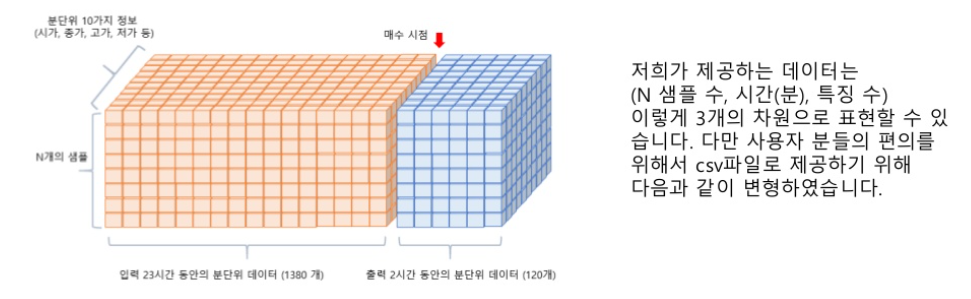

# 1.데이터전처리

원하는 데이터 shape  # sample_id(batch), nfeature, sample_id, 1


target(y) # open

## 1.1 Scaling을 진행하였습니다
- X_scaler_with_std
- X_scaler_without_std
- Y_scaler_without_std



In [ ]:
### einsum 활용

# A = tf.Tensor([3], shape=(1,), dtype=tf.float32)

# B = tf.random.normal([2,4])
# tf.einsum('nq,pu->nq', A, B)


In [ ]:
######## Encoder와 Decoder의 Input입니다 ########
## Train_X scaling
# 1. 원래의 std가 1을 넘는 column은 with_std scaling
# 2. 원래의 std가 1 안넘으면 mean으로만 scaling

X_column_scale_both = []
X_column_scale_mean = []
#### 각 column별로 std 조사
for c in [column for column in train_x_df.columns if column not in ('sample_id','time')]:
    if train_x_df.loc[:,c].std()>1:
        X_column_scale_both.append(c)
    else:
        X_column_scale_mean.append(c)

#### with std ( X_scaler_with_std )
# X_scaler_with_std = StandardScaler(with_std=True)
X_scaler_with_std = MinMaxScaler()
X_scaler_with_std.fit(train_x_df.loc[:,X_column_scale_both])
# print(X_scaler_with_std.var_)
train_x_df.loc[:,X_column_scale_both] = X_scaler_with_std.transform(train_x_df.loc[:,X_column_scale_both])

#### without std ( X_scaler_without_std )
# X_scaler_without_std = StandardScaler(with_std=False)
# X_scaler_without_std = MinMaxScaler(with_std=False)
# X_scaler_without_std.fit(train_x_df.loc[:,X_column_scale_mean])
# print(X_scaler_without_std.var_)
# train_x_df.loc[:,X_column_scale_mean] = X_scaler_without_std.transform(train_x_df.loc[:,X_column_scale_mean])
print("X_train scaling 완료")
# print(train_x_df.describe())


#### Test_X scaling
test_x_df.loc[:,X_column_scale_both] = X_scaler_with_std.transform(test_x_df.loc[:,X_column_scale_both])
# test_x_df.loc[:,X_column_scale_mean] = X_scaler_without_std.transform(test_x_df.loc[:,X_column_scale_mean])
print("X_test scaling 완료")
# print(test_x_df.describe())


######## Decoder Label입니다 ############

#### Train_y scaling
#### 사실 현재 이 노트북에서는 open 변수만을 예측하는 모델을 설계할 것입니다.
#### 따라서 target인 open 변수만 빼옵니다. (후에 sample_id 별로 나눠야 함.)
train_y_df = train_y_df.loc[:,['sample_id','time','open']]

## -------------------------------------
#### inverse Transform 시에는
## ------------------------------------
#### y_mean  값을 더해주기만 하면 된다.
## ------------------------------------
y_mean = train_y_df['open'].mean()
train_y_df['open'] = train_y_df['open'] #-y_mean
print("Y_test scaling 완료")
print(train_y_df.describe())

X_train scaling 완료
X_test scaling 완료
Y_test scaling 완료
           sample_id           time           open
count  883440.000000  883440.000000  883440.000000
mean     3680.500000      59.500000       1.000065
std      2125.227524      34.639833       0.012062
min         0.000000       0.000000       0.776689
25%      1840.000000      29.750000       0.996483
50%      3680.500000      59.500000       1.000000
75%      5521.000000      89.250000       1.003615
max      7361.000000     119.000000       1.243545


In [ ]:
train_x_df.describe()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
count,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07,1.015956e+07
mean,3.680500e+03,6.895000e+02,6.106583e-01,1.000988e+00,1.001753e+00,1.000196e+00,1.000980e+00,1.035121e-04,1.152047e-03,1.885110e-03,4.969559e-05,9.078090e-04
std,2.125226e+03,3.983716e+02,3.266672e-01,3.895120e-02,3.900216e-02,3.889973e-02,3.892255e-02,1.262638e-03,5.792529e-03,7.888007e-03,7.177828e-04,4.818493e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,8.903663e-02,5.540227e-01,8.903663e-02,5.540227e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.840000e+03,3.447500e+02,4.444444e-01,9.871310e-01,9.878350e-01,9.863969e-01,9.871426e-01,6.823095e-12,8.436738e-07,1.232875e-06,7.726728e-13,4.595701e-07
50%,3.680500e+03,6.895000e+02,6.666667e-01,1.000000e+00,1.000556e+00,9.994500e-01,1.000000e+00,4.367700e-10,8.690354e-06,1.245823e-05,1.415588e-10,4.968505e-06
75%,5.521000e+03,1.034250e+03,8.888889e-01,1.012693e+00,1.013415e+00,1.011950e+00,1.012669e+00,5.756142e-06,3.385412e-04,9.015821e-04,1.228333e-06,2.096396e-04
max,7.361000e+03,1.379000e+03,1.000000e+00,2.066901e+00,4.451831e+00,2.066901e+00,2.066901e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
test_x_df.describe()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
count,730020.000000,730020.000000,730020.000000,730020.000000,730020.000000,730020.000000,730020.000000,7.300200e+05,730020.000000,730020.000000,7.300200e+05,730020.000000
mean,264.000000,689.500000,0.499055,0.991427,0.993138,0.989688,0.991434,1.054573e-04,0.005376,0.005010,5.317937e-05,0.004278
std,152.708978,398.371854,0.318702,0.066288,0.066522,0.066000,0.066239,5.053219e-04,0.023139,0.015623,2.732300e-04,0.018397
min,0.000000,0.000000,0.000000,0.607767,0.609716,0.606567,0.608217,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,132.000000,344.750000,0.222222,0.963017,0.964617,0.961381,0.963066,1.090070e-10,0.000014,0.000010,4.971006e-11,0.000010
50%,264.000000,689.500000,0.444444,0.995372,0.996856,0.993898,0.995397,5.392450e-08,0.000138,0.000158,2.259849e-08,0.000095
75%,396.000000,1034.250000,0.777778,1.021444,1.023017,1.019826,1.021421,4.869166e-05,0.002442,0.004283,1.970453e-05,0.001770
max,528.000000,1379.000000,1.000000,2.129188,2.167028,1.950575,2.129188,6.404509e-02,2.477305,1.268600,3.072958e-02,1.586727


In [ ]:
print(len(set(train_x_df.sample_id)))
print(len(set(train_y_df.sample_id)))

print(len(set(train_x_df.time)))
print(len(set(train_y_df.time)))


7362
7362
1380
120


In [ ]:
# sample_id마다 데이터는 독립적이므로 따로 고려한다.
# sample_id(batch), nfeature, time, 1
 # 현재 train의 목표 shape = (7362, 10, 1380, 1)
x_train_ori = np.array([x.values[:,2:].T for group,x in train_x_df.groupby('sample_id')],'float32')
x_train_ori = x_train_ori[:,:,:,np.newaxis]
print(x_train_ori.shape) # sample_id(before batch), nfeature, time, 1 = (7362, 10, 1380, 1)

(7362, 10, 1380, 1)


In [ ]:
# y값입니다.
# start token으로 0을 앞에 추가해주었습니다.
y_train_ori = np.array([np.append([0],y.values[:,2].T, axis=0) for group,y in train_y_df.groupby('sample_id')],'float32')
y_train_ori.shape

(7362, 121)

In [ ]:
 # 현재 test_x의 목표 shape = (529, 10, 1380, 1)
x_test = np.array([x.values[:,2:].T for group,x in test_x_df.groupby('sample_id')],'float32')
x_test = x_test[:,:,:,np.newaxis]
print(x_test.shape) # sample_id(before batch), nfeature, time, 1 = (529, 10, 1380, 1)

(529, 10, 1380, 1)


In [ ]:
# Visualization of X Variables
def vis(uid):
    # plt.plot(x_train_ori[uid][0,:,0])   # coin_index
    # plt.show()
    plt.plot(x_train_ori[uid][1,:,0])   # open
    plt.plot(x_train_ori[uid][2,:,0])   # high
    plt.plot(x_train_ori[uid][3,:,0])   # low
    plt.plot(x_train_ori[uid][4,:,0])   # close
    plt.show()
    plt.plot(x_train_ori[uid][5,:,0])   # volume
    # plt.plot(x_train_ori[uid][6,:,0])   # quote_av
    # plt.plot(x_train_ori[uid][7,:,0])   # trades
    # plt.plot(x_train_ori[uid][8,:,0])   # tb_base_av
    # plt.plot(x_train_ori[uid][9,:,0])   # tb_quote_av
    # plt.show()

In [ ]:
# vis(0)  # sample_id==0

In [ ]:
# 모델 구축시에는 (맨아래에서) K-Fold를 수행할것이지만,
# 모델링 전에 tensorsize를 중간중간 코드 중에 체크해보기 위해서
# 임의로 나눈 train valid split입니다.

x_train, x_val, y_train, y_val = train_test_split(x_train_ori, y_train_ori, test_size=0.1, random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(6625, 6625, 737, 737)

#  2.Data Augmentation

1)아래의 예시들은 shift이다 (영상 데이터에 많이 쓰는 기법이다.)

    - 사진이 있으면 일정 간격씩 미루어버리는 것이다. (np.roll 사용)
    - 어느 간격씩 미루었는가에 따라 몇배가 된다 (아래의 예시에선 데이터양이 5배가 되었다)

현재 데이터는 time series니까

    - 시간을 축으로서 미루어서 데이터를 추가생성해도 될 듯하다.

    - 우선 이 노트북에선 구현하지 않고 다음 노트북에서 실험해보겠다.

shift 기법 이외에도

2) np.flip을 이용하여 데이터의 시간순서를 아예 뒤집어버리는 것도 좋아 보인다. (데이터 양이 2배) 

    (즉, 0~1379 train_x를 1379~0 순서로 바꾸어버리기, 이때 y의 순서는 1380~1499 그대로 유지해야 의미가 있을 것이다.)

※ flip을 일단 써보았지만, 유용할지는 모르겠다.. 오히려 성능을 방해하지 않을까?

※ 그리고, 일단 flip 만들어봤고, shuffle을 쓰긴 했는데 이렇게 augmentation을 적용한 후에 data를 shuffle 해줘도 되는건지 모르겠다..

> 그래서 결국 이 노트북에선 flip 안써봄, generator로 만들때 오류도 남..

In [ ]:
##### 1. shift #####

# y는 그대로 두고 x만 일정 time씩 미루어서 데이터를 새로 생성
# def shift(x, y):
#     n_times = 5 # 5배로 데이터를 늘리겠다.
#     new = []
#     for i in range(n_times):  # 1380/5만큼 미루어서 만든 새로운 train 5개
#         temp = np.roll(x, i*int(1380/n_times), axis=1)
#         new.extend(temp)
#     x = np.array(new)
#     y = np.concatenate([y]*5)
#     x, y = shuffle(x, y, random_state=42)
#     return x,y

# 위의 function은 일정 간격씩 데이터를 미뤘다면
# 아래는 일정하지 않은 어떤 random값 간격으로 데이터를 미루었습니다.
# def map_func(x_train, y_train):
#     x_train = random_shift(x_train)
#     return x_train, y_train

# def random_shift(data):
#     shift = int(random.random()*1380)
#     data = np.roll(data, shift, axis=1)
#     return data


#### 2. flip ####
## 시간을 반대로 뒤집는flip을 한 후에 결과를 바로 array에 추가해서
## 데이터를 2배로 만들고 학습을 하게 된다. (주의할 점은 y label은 그대로 둬야 한다는 것)

def add_flip(x,y):
    flip = np.flip(x, axis=1)
    x = np.concatenate([x,flip])
    y = np.concatenate([y]*2)
    x,y = shuffle(x, y, random_state=42)
    return x,y

In [ ]:
add_flip(x_train,y_train)[0].shape # (x_train, y_train)[0] = x_train

(13250, 10, 1380, 1)

# 3.하이퍼파라미터

논문에서 사용한 하이퍼파라미터
- d_model = 512
- d_ff = 2048
- heads = 8
- d_k = 64
- d_v = 64
- dropout = 0.1
- train_steps = 100K
- d_model = 512
- d_ff = 2048
- heads = 8
- d_k = 64
- d_v = 64
- dropout = 0.1
- train_steps = 100K

In [ ]:
BATCH_SIZE = 32     # 64
EPOCHS = 50
early_stopping = 10
k = 9               # K-Fold
learning_rate = 5e-5

num_layers = 2      # 6 # 인코더와 디코더의 각 층 수, 논문에서는 인코더도 6층 디코더도 6층
dff = 512           # 2048 # 인코더와 디코더 내부에서 중간 층의 노드수이다. 예를 들어서 만약 (d_model,dff)=(512,2048)로 설정했다면,
                           # 인코더와 디코더 각각 내부에서의 피드포워드신경망은 다음과 같이 진행된다. (input_size, output_size)
                           # (512,2048) -> (2048,512), 결국 인풋과 아웃풋으로서 d_model을 가지며 중간에 거쳐가는 사이즈.
                           # 위와 같은 숫자의 상황에서는 이것의 앞단에서는 포지셔널 임베딩 층이 있었고 512차원으로 임베딩 벡터를 출력했었을 것이다.

num_heads = 4       # 8   multi-head attention에서 head 수        # d_model을 num_heads로 나눈 몫이 Q,K,V 벡터의 차원수으로 쓰이게 됩니다. (==Q,K,V 가중치 matrix의 column수)
dropout_rate = 0.2  # Fully Connected Layer에서 dropout rate
d_model = 128       # 512 # 각 t번째 시점의 토큰을 몇차원으로 할지. 즉, 이는 인코더와 디코더 내부에서 입력과 출력을 몇으로 할지이다. 입력과 출력 사이즈는 같다
                    # 인코더와 디코더 내부에서 각각 다음 인코더 층, 다음 디코더 층으로 갈때 d_model 차원으로 유지된다. (포지셔널 인코딩에 d_model/2가 쓰이므로 2의 배수여야 함.)

base_channel = 16   # 각 Conv층마다의 필터의 개수 결정하는 데 base가 되는 채널수
target_size = 120    # 61 # decoder 의 아웃풋 사이즈


In [ ]:
x_train.shape

(6625, 10, 1380, 1)

In [ ]:
tf.data.Dataset.from_tensor_slices(x_train)

<TensorSliceDataset shapes: (10, 1380, 1), types: tf.float32>

# 4.데이터구성 연습 (generator)

In [ ]:
56320/128

440.0

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(add_flip, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(add_flip, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(x_val.shape[0])
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 10, 1380, 1]), TensorShape([32, 121]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([737, 10, 1380, 1]), TensorShape([737, 121]))

# 5.모델 정의


참고 : https://wikidocs.net/31379



## 5.0 PºEncoder, M-H-A, Position Wise FFN

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
# 이때, 룩-어헤드 마스크를 한다고해서 패딩 마스크가 불필요한 것이 아니므로 룩-어헤드 마스크는 패딩 마스크를 포함하도록 구현합니다. 
# 룩-어헤드 마스크를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴하도록 합니다.

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
                                ])

## 5.1 인코더

6x600의 입력데이터를 1x2 커널을 활용해 다른 데이터끼리 간섭 없이 convolution 및 pooling 진행

In [ ]:
class EncoderLayer(tf.keras.Model):
    def __init__(self, d_model, num_heads, dff, rate):
        super(EncoderLayer, self).__init__()
        
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        
        self.pos_encoding = positional_encoding(500, d_model)       
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x):        
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        
        attn, attn_weights_block = self.mha1(x, x, x, None)  # (batch_size, target_seq_len, d_model)
        attn = self.dropout1(attn)
        # 잔차 연결
        out = self.layernorm1(attn + x)
        
        ffn_output = self.ffn(out)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        # 잔차 연결
        out = self.layernorm2(ffn_output + out)
        
        return out

In [ ]:
# Conv, pooling 참고 : https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate):
        super(Encoder, self).__init__()
        
        self.num_layers = num_layers
        self.feature_extract_model = self.cnn_base(base_channel)
        self.fc = tf.keras.layers.Dense(d_model, activation='relu')
        self.pos_encoding = positional_encoding(440, d_model)
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]

    def call(self, x, training):
        x = self.feature_extract_model(x)
        x = tf.keras.layers.Reshape((-1, x.shape[3]))(x)
        x = self.fc(x)
        seq_len = tf.shape(x)[1]
        #print(seq_len)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        # encoder layer 여러층 쌓기
        for i in range(self.num_layers):
           x = self.enc_layers[i](x)
        
        x = tf.keras.layers.Reshape((1, -1))(x)
        
        return x  # (batch_size, input_seq_len, d_model)
    
    def cnn_base(self, base_channel=8): # 말그대로 임의로 설정한 base_channel수, 16, 32, 64 등으로 아래에서 설정하고 있음
                                        # 컨볼루션 필터의 개수로 쓰임.
        input_layer = tf.keras.layers.Input(shape=(10, 1380, 1))
        
        x = tf.keras.layers.Conv2D(base_channel*2, (1, 2), activation='relu', padding='same')(input_layer)  # 컨볼루션 커널의 차원 (행,열),
        x = tf.keras.layers.BatchNormalization()(x)                                                         # padding='same'을 통해 (입력사이즈 = 출력 사이즈) 사이즈 그대로 유지
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)
        
        x = tf.keras.layers.Conv2D(base_channel*4, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*8, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*16, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        x = tf.keras.layers.Conv2D(base_channel*32, (1, 2), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((1, 2), padding='same', strides=(1,2))(x)

        output_layer = tf.keras.layers.Conv2D(base_channel*64, (1, 2), activation='relu', padding='same')(x)
        
        return tf.keras.models.Model(input_layer, output_layer)

In [ ]:
# 인코더 실험해보기

sample_encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, rate=dropout_rate)
temp_input = next(iter(train_dataset))[0]

sample_encoder_output = sample_encoder(temp_input, False)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(32, 1, 56320)


In [ ]:
56320/128

440.0

## 5.2 디코더

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3 #, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            #attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x#, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_size=target_size,
                         maximum_position_encoding=500)
temp_input = next(iter(train_dataset))[1]   #tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
temp_input.shape


TensorShape([32, 121])

In [ ]:
output = sample_decoder(temp_input, 
                        enc_output=sample_encoder_output, 
                        training=False,
                        look_ahead_mask=None, 
                        padding_mask=None)

output.shape #, attn['decoder_layer2_block2'].shape

TensorShape([32, 121, 512])

## 5.3 트랜스포머

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_size, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, dropout_rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_size)
        # self.final_layer = tf.keras.layers.Dense(target_size, activation='softmax')
        # self.final_layer = tf.keras.layers.Dense(target_size, activation='tanh')

    def call(self, inp, tar, training, look_ahead_mask, dec_padding_mask, batch_size):
        # print(f"d_model : {d_model}")

        enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model)
        # print(f"enc_output : {enc_output.shape}")
        
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask) # dec_output : (32, 120, 128) <- flatten이 필요할듯하다.
        dec_output = tf.reshape(dec_output, shape = [enc_output.shape[0],-1])   # 차원을 (batch_size, target_size*)로 바꿔줘야 한다. (flatten)
        # print(f"dec_output : {dec_output.shape}")
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_size)
        # print(f"final_output : {final_output.shape}")
        # print('='*20,'final Output 출력', '='*20)
        
        return final_output#, attention_weights

## 5.4 Optimizer with Scheduler

>논문에서는 다음과 같이 LR을 정의하였습니다.(아래는 논문에서 선택한 value)
- d_model = 512
- train_steps = 100K
- warmup_steps = 4000


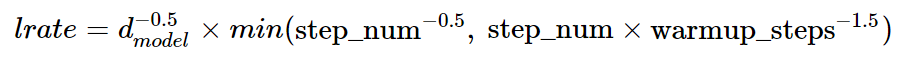


참고 : https://arxiv.org/pdf/1706.03762.pdf

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
sample_learning_rate = CustomSchedule(d_model=512)

plt.plot(sample_learning_rate(tf.range(100000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [ ]:
# learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## 5.5 loss 함수 정의 

In [ ]:
# def loss_object(y, y_hat):
#     y = tf.one_hot(tf.cast(y, tf.int32), target_size)
#     return tf.keras.losses.categorical_crossentropy(y, y_hat, from_logits=False, label_smoothing = 0.0)

# tf.keras.losses.mean_squared_error
# tf.keras.losses.mean_absolute_error

def loss_object(y, y_hat):
    # y = tf.one_hot(tf.cast(y, tf.int32), target_size)
    return tf.keras.losses.mean_absolute_error(y, y_hat)


In [ ]:
def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_sum(loss_)


# def loss_function(real, pred):
#     mask = tf.math.logical_not(tf.math.equal(real, -1))
#     loss_ = loss_object(real, pred)
#     mask = tf.cast(mask, dtype=loss_.dtype)
#     loss_ *= mask

#     return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


# def accuracy_function(real, pred):
#     real = tf.dtypes.cast(real, tf.int64)
#     accuracies = tf.equal(real, tf.argmax(pred, axis=2))
#     mask = tf.math.logical_not(tf.math.equal(real, -1))
#     accuracies = tf.math.logical_and(mask, accuracies)

#     accuracies = tf.cast(accuracies, dtype=tf.float32)
#     mask = tf.cast(mask, dtype=tf.float32)
#     return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          target_size, 
                          pe_target=target_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask

In [ ]:
next(iter(train_dataset))[0].shape

TensorShape([32, 10, 1380, 1])

In [ ]:
next(iter(train_dataset))[1][:,:-1].shape

TensorShape([32, 120])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(add_flip, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(add_flip, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(x_val.shape[0])
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
inp = next(iter(train_dataset))[0]
tar_inp = next(iter(train_dataset))[1][:,:-1]
combined_mask = create_masks(tar_inp)
transformer(inp, tar_inp, True, combined_mask, dec_padding_mask=None, batch_size=BATCH_SIZE).shape

d_model : 128
enc_output : (32, 1, 56320)
dec_output : (32, 15360)
final_output : (32, 120)
==================== final Output 출력 ====================


TensorShape([32, 120])

In [ ]:
inp.shape

TensorShape([32, 10, 1380, 1])

In [ ]:
tar_inp.shape

TensorShape([32, 120])

In [ ]:
@tf.function()
def train_step(inp, tar, training=True):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    with tf.GradientTape() as tape:
        predictions = transformer(inp, tar_inp,
                                  True,
                                  None,
                                  None,
                                  batch_size=BATCH_SIZE)
        loss = loss_function(tar_real, predictions)
    if training==True:
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # train_accuracy(accuracy_function(tar_real, predictions))
    else:
        pass
        # val_accuracy(accuracy_function(tar_real, predictions))
  
    return loss, predictions

In [ ]:
# train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
# val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')
gc.collect()

8352

In [ ]:
tensor = next(iter(train_dataset))[0]
target = next(iter(train_dataset))[1]
print(tensor.shape)
print(target.shape)

predictions = transformer(tensor,target[:, :-1],True, None, None,batch_size=BATCH_SIZE)
print(predictions.shape)
tar_real = target[:, 1:]
print(tar_real.shape)

(32, 10, 1380, 1)
(32, 121)
d_model : 128
enc_output : (32, 1, 56320)
dec_output : (32, 15360)
final_output : (32, 120)
==================== final Output 출력 ====================
(32, 120)
(32, 120)


In [ ]:
print(np.array(tar_real).max())
print(np.array(tar_real).min())

1.0416979
0.9434226


In [ ]:
print(np.array(predictions).max())
print(np.array(predictions).min())

2.7296011
-0.7162971


In [ ]:
loss_function(tar_real,predictions)

<tf.Tensor: shape=(), dtype=float32, numpy=12.2122965>

# 6.체크포인트 설정


In [ ]:
ls

 사진/
'0314 LSTM with KFold 처음부터 짜보기.ipynb'
'1등(20210310)_BitTrader_LSTM_Tutorial_NoValidation(2)_scaler없이_120까지로_중간에끊음.ipynb'
'20210311(1등파일 재현성 이슈)_BitTrader_LSTM_Tutorial_NoValidation(2)_scaler없이_120까지로_중간에끊음.ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(1).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(2).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(3).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(4).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(7)_scaler없이_120까지만_중간에끊음.ipynb'
'BitTrader_LSTM_Tutorial_Validation추가해보기(8).ipynb'
 BitTrader_RNN.ipynb
 checkpoints_transformer/
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인114(수정).ipynb'
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인116.ipynb'
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인117(수정).ipynb'
 data/
'fbprophet을_활용한 초급자 베이스라인.ipynb'
 Keras_LSTM.ipynb
 model/
'Pytorch LSTM.ipynb'
'(shape을 잘못생각해서 ᄉ

In [ ]:
!rm -r ./checkpoints_transformer

In [ ]:
init_path = "./checkpoints_transformer/init"
import os
if not os.path.isdir(init_path):
    os.makedirs(init_path)
init_ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
init_ckpt_manager = tf.train.CheckpointManager(init_ckpt, init_path, max_to_keep=5)


In [ ]:
init_ckpt_manager.save()

'./checkpoints_transformer/init/ckpt-1'

# 7.K-Fold Slided CV

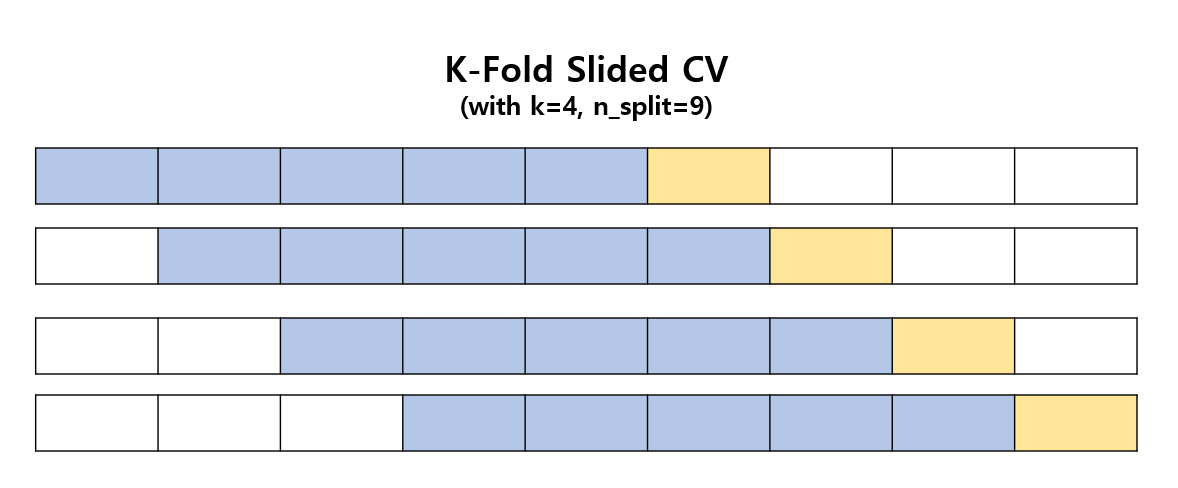

In [ ]:
x_train_ori.shape[0]/9

818.0

In [ ]:
## Slided CV는 구현이 되어있는 곳을 찾기 힘들어서 직접 구현하였습니다.

class k_slided_fold:
    def __init__(self,n_split, k):
        self.n_split = n_split
        self.k = k

    def split(self,x_input,y_input):
        assert x_input.shape[0]==y_input.shape[0]
        n_split = self.n_split
        k = self.k
        train_len = n_split-k
        total_len = x_input.shape[0]

        train_val_idx = [ 
                 [  
                  list(range(total_len//n_split*(k_ind) , total_len//n_split*(k_ind+train_len) ) ), 
                  list(range(total_len//n_split*(k_ind+train_len) , total_len//n_split*(k_ind+train_len+1) )) 
                  ] 
                 for k_ind in range(k) 
                 ]

        return train_val_idx

In [ ]:
# ValueError: Dimensions must be equal, but are 120 and 32 for '{{node sub}} = Sub[T=DT_FLOAT](transformer_3/dense_178/BiasAdd, strided_slice_1)' with input shapes: [32,120,120], [32,120].
# loss function에서 차원이 안맞아서 나는 오류였음

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          target_size, 
                          pe_target=target_size,
                          rate=dropout_rate)

Init checkpoint restored!!


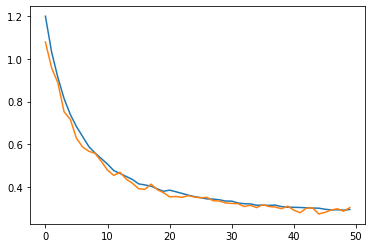

Init checkpoint restored!!


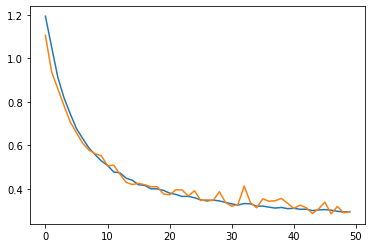

In [ ]:
# k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
k=2
n_split=9

k_fold = k_slided_fold(n_split=n_split, k=k)
val_loss_dict = {}  # 각 Fold시마다 모아놓은 val_loss_list를 저장
for i, (train_idx, val_idx) in enumerate(k_fold.split(x_train_ori, y_train_ori[:,1])):
    x_train, y_train = x_train_ori[train_idx], y_train_ori[train_idx]
    x_val, y_val = x_train_ori[val_idx], y_train_ori[val_idx]
    
    # x_train, y_train = shift(x_train, y_train)
    #x_val, y_val = shift(x_val, y_val)
    # x_train, y_train = shuffle(x_train, y_train)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    # train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    # val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    if init_ckpt_manager.latest_checkpoint:
        init_ckpt.restore(init_ckpt_manager.latest_checkpoint)
        print ('Init checkpoint restored!!')
    
    checkpoint_path = f"./checkpoints_transformer/model_{i}"

    ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5,
                                            #   checkpoint_interval=5 # checkpoint 몇번 간격마다 저장할지
                                              )   
    loss_plot, val_loss_plot = [], []
    for epoch in range(EPOCHS):
        total_loss, total_val_loss = 0, 0
        # train_accuracy.reset_states()
            
        tqdm_dataset = tqdm(enumerate(train_dataset))
        
        for (batch, (tensor, target)) in tqdm_dataset:
            
            batch_loss, pred_list = train_step(tensor, target, training=True)
            total_loss += batch_loss
            
            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Train Loss': '{:06f}'.format(batch_loss.numpy()),
                'Train Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
                # 'Accuracy':train_accuracy.result().numpy(), 
            })
            if batch % 30 == 0:
                gc.collect()

        loss_plot.append(total_loss / (batch+1))
        
        # val_accuracy.reset_states()
        
        tqdm_dataset_val = tqdm(enumerate(val_dataset))

        for (batch, (tensor, target)) in tqdm_dataset_val:

            batch_val_loss, pred_list = train_step(tensor, target, training=False)
            total_val_loss += batch_val_loss
            
            tqdm_dataset_val.set_postfix({
                'Epoch': epoch + 1,
                'k': i,
                'Val Loss': '{:06f}'.format(batch_val_loss.numpy()),
                'Val Total_Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
                # 'Val Accuracy':val_accuracy.result().numpy(), 
            })
            
        val_loss_plot.append(total_val_loss / (batch+1))
        
        if epoch>=early_stopping and epoch%5==0 and np.min(val_loss_plot) == val_loss_plot[-1]: # epoch이 5의 배수이면서 early stopping 지나고, loss가 최소일 때만 모델저장
            ckpt_manager.save()
            print('check_point saved')
        
        if epoch >= early_stopping and np.min(val_loss_plot[-early_stopping:]) == val_loss_plot[-early_stopping]:
            break
    val_loss_dict[i] = val_loss_plot
    plt.plot(loss_plot)
    plt.plot(val_loss_plot)
    plt.show()

In [ ]:
len(val_loss_plot)

50

In [ ]:
min_val = [(0,float(val_loss_plot[0]))]
for ind in range(len(val_loss_plot)):
    if float(val_loss_plot[ind])<min_val[-1][-1]:
        min_val.pop()
        min_val.append((ind,float(val_loss_plot[ind])))
min_val

[(46, 0.2843583822250366)]

In [ ]:
gc.collect()

88

# 8.Infefence

$$
predictions = \\
 min[ log_{10}{(\hat{y}-1)*100},\ \ 1] \ (if \ \hat{y}>1)
\\
0\ \ if(y<1)
$$






$$

$$

In [ ]:
test_batch_size = 1
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
# test_dataset = test_dataset.map(lambda item1: tf.numpy_function(test_map_func, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(test_batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
@tf.function
def evaluate(tensor):
    decoder_input = [0] * tensor.shape[0]
    output = tf.expand_dims(decoder_input,1)
    # print(f'tensor shape : {tensor.shape}')
    # print(f'output shape : {output.shape}')
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(tensor,
                              output,
                              False,
                              None,
                              None,
                              batch_size=test_batch_size
                              )
    # print('prediction 완료')
    # print(f'predictions shape : {predictions.shape}')

    # select the last word from the seq_len dimension
    predictions = predictions[: ,:]  # (batch_size, target_size)

    return predictions
output = evaluate(next(iter(test_dataset)))    # next(iter(test_dataset))[0]
output

In [ ]:
tensor = next(iter(test_dataset))
print(tensor.shape)

decoder_input = [0] * tensor.shape[0]
output = tf.expand_dims(decoder_input,1)
print(output.shape)

(1, 10, 1380, 1)
(1, 1)


In [ ]:
# transformer = Transformer(num_layers, d_model, num_heads, dff,
#                           target_size, 
#                           pe_target=target_size,
#                           rate=dropout_rate
#                           )

# transformer(tensor,output,False,None,None)

In [ ]:
## test set
test_batch_size = 1
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
# test_dataset = test_dataset.map(lambda item1: tf.numpy_function(test_map_func, [item1], [tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(test_batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

preds = []

for i in range(k):
    checkpoint_path = f"./checkpoints_transformer/model_{i}"
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
    
    pred = []
    for batch in iter(test_dataset):
        output = evaluate(batch)
        pred.extend(output)
    pred = np.array(pred)
    preds.append(pred)

In [ ]:
# 앙상블
from copy import deepcopy
total_pred = deepcopy(preds[0])
for ind in range(1,len(preds)):
    total_pred+=preds[ind]
total_pred/len(preds)

===


array([[-0.90518475,  0.92760265,  0.14043795, ..., -0.38382608,
        -0.59014016, -0.11660457],
       [-0.9061449 ,  0.92414296,  0.14113548, ..., -0.38395765,
        -0.58984923, -0.11491442],
       [-0.90654397,  0.9246949 ,  0.14060706, ..., -0.38396096,
        -0.59061694, -0.1151157 ],
       ...,
       [-0.90570116,  0.92623633,  0.1406891 , ..., -0.3837885 ,
        -0.5898145 , -0.11591154],
       [-0.90520155,  0.9275234 ,  0.14046179, ..., -0.38384864,
        -0.5901127 , -0.11659014],
       [-0.9054092 ,  0.926438  ,  0.14068818, ..., -0.3839116 ,
        -0.5900502 , -0.11614811]], dtype=float32)

In [ ]:
max_value_time_array = np.column_stack([total_pred.max(axis=1),total_pred.argmax(axis=1)])
print(max_value_time_array.shape)
threshold = 1+ min_val[-1][-1]
higher = max_value_time_array[:,0]>threshold
lower = max_value_time_array[:,0]<threshold

max_value_time_array[higher,0]=1
max_value_time_array[lower,0]=0
max_value_time_array

(529, 2)


array([[ 1., 69.],
       [ 1., 69.],
       [ 1., 69.],
       ...,
       [ 1., 69.],
       [ 1., 69.],
       [ 1., 69.]])

In [ ]:
submission[['buy_quantity']]=max_value_time_array[:,0]
submission['sell_time'] = max_value_time_array[:,1].astype(int)
submission

,sample_id,buy_quantity,sell_time
0,0,1.0,69
1,1,1.0,69
2,2,1.0,69
3,3,1.0,69
4,4,1.0,69
...,...,...,...
524,524,1.0,69
525,525,1.0,69
526,526,1.0,69
527,527,1.0,69


# 9.submission

In [ ]:
ls

 사진/
'0314 LSTM with KFold 처음부터 짜보기.ipynb'
'1등(20210310)_BitTrader_LSTM_Tutorial_NoValidation(2)_scaler없이_120까지로_중간에끊음.ipynb'
'20210311(1등파일 재현성 이슈)_BitTrader_LSTM_Tutorial_NoValidation(2)_scaler없이_120까지로_중간에끊음.ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(1).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(2).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(3).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(4).ipynb'
'BitTrader_LSTM_Tutorial_NoValidation(7)_scaler없이_120까지만_중간에끊음.ipynb'
'BitTrader_LSTM_Tutorial_Validation추가해보기(8).ipynb'
 BitTrader_RNN.ipynb
 checkpoints_transformer/
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인114(수정).ipynb'
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인116.ipynb'
'Dacon_인공지능_비트 트레이더 경진대회 베이스라인117(수정).ipynb'
 data/
'fbprophet을_활용한 초급자 베이스라인.ipynb'
 Keras_LSTM.ipynb
 model/
'Pytorch LSTM.ipynb'
'(shape을 잘못생각해서 ᄉ

In [ ]:
from datetime import datetime
today_date = datetime.today().strftime("%m-%d")

import os 
folder_path = f"{today_date}_transformer_batch_{BATCH_SIZE}_epoch_{epoch}_d_model_{d_model}_num_heads_{num_heads}"
if not os.path.isdir("submission_transformer/"+folder_path):
    os.makedirs(folder_path)

submission_path = "submission_transformer/"+f"./{folder_path}/{folder_path}_submission"

submission.to_csv(f'{submission_path}.csv',index=False)

In [ ]:
pd.read_csv(f'{submission_path}.csv')

,sample_id,buy_quantity,sell_time
0,0,1.0,69
1,1,1.0,69
2,2,1.0,69
3,3,1.0,69
4,4,1.0,69
...,...,...,...
524,524,1.0,69
525,525,1.0,69
526,526,1.0,69
527,527,1.0,69
